__Задание 0:__ _выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели._

In [1]:
import warnings
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt

from tqdm import tqdm
from boostaroota import BoostARoota
from sklearn.metrics import roc_auc_score

warnings.simplefilter("ignore")
shap.initjs()
%matplotlib inline

In [2]:
train = pd.read_csv("data/new_feature_train.csv", index_col=0)
valid = pd.read_csv("data/new_feature_valid.csv", index_col=0)
test = pd.read_csv("data/new_feature_test.csv", index_col=0)

print("train.shape = {} rows, {} cols".format(*train.shape))
print("valid.shape = {} rows, {} cols".format(*valid.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 126000 rows, 434 cols
valid.shape = 54000 rows, 434 cols
test.shape = 100001 rows, 434 cols


In [3]:
train.head()

,TransactionID,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,D15_addr2_mean,D15_card1|card2_mean,D15_card1|card2|card3|card5_mean,D15_card1|card2|card3|card5|addr1|addr2_mean,TransactionAmtInt,TransactionAmtFrac,TransactionAmtLog,P_emaildomain_freq_enc,R_emaildomain_freq_enc,isFraud
0,3124327,117.0,W,2772,512.0,150.0,visa,226.0,debit,310.0,...,0.000000,0.00000,0.00000,0.0,117,0.0,4.762174,0.003619,0.665952,0
1,3013253,50.0,H,3663,307.0,150.0,visa,226.0,debit,264.0,...,NaN,NaN,NaN,NaN,50,0.0,3.912023,0.161111,0.031063,0
2,3165369,59.0,W,9128,555.0,150.0,visa,166.0,debit,476.0,...,0.000000,0.00000,0.00000,NaN,59,0.0,4.077537,0.158063,0.665952,0
3,3080470,100.0,R,1668,399.0,150.0,american express,198.0,credit,330.0,...,NaN,NaN,NaN,NaN,100,0.0,4.605170,0.083508,0.055921,0
4,3161901,29.0,W,8431,269.0,150.0,mastercard,224.0,debit,299.0,...,0.017595,0.01921,0.01921,2.0,29,0.0,3.367296,0.373214,0.665952,0


In [4]:
target = "isFraud"

categorical_features = train.select_dtypes(exclude=[np.number]).columns.tolist()
train[categorical_features] = train[categorical_features].astype('category')
valid[categorical_features] = valid[categorical_features].astype('category')
test[categorical_features] = test[categorical_features].astype('category')

x_train, y_train = train.drop(columns=target), train[target]
x_valid, y_valid = valid.drop(columns=target), valid[target]
x_test, y_test = test.drop(columns=target), test[target]

del train, valid, test

In [5]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "n_jobs": -1,
    "seed": 27
}

In [6]:
def get_trained_model(x_train, y_train, x_valid, y_valid, categorical_features, params):

    dtrain = lgb.Dataset(data=x_train, label=y_train, categorical_feature=categorical_features)
    dvalid = lgb.Dataset(data=x_valid, label=y_valid, categorical_feature=categorical_features)

    model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=1000,
        categorical_feature=categorical_features,
        valid_sets=[dtrain, dvalid],
        early_stopping_rounds=10,
        verbose_eval=20
    )
    
    return model

In [7]:
def get_predict(model, x_train, y_train, x_valid, y_valid, x_test, y_test):
    pred_train = model.predict(x_train)
    pred_valid = model.predict(x_valid)
    pred_test = model.predict(x_test)

    print(f"Train-score: {round(roc_auc_score(y_train, pred_train), 5)}\n"
          f"Valid-score: {round(roc_auc_score(y_valid, pred_valid), 5)}\n"
          f"Test-score: {round(roc_auc_score(y_test, pred_test), 5)}")
    
    return pred_train, pred_valid, pred_test

In [8]:
model_base = get_trained_model(x_train, y_train, x_valid, y_valid, categorical_features, params)

Training until validation scores don't improve for 10 rounds
[20]	training's auc: 0.96586	valid_1's auc: 0.921272
[40]	training's auc: 0.983304	valid_1's auc: 0.933241
[60]	training's auc: 0.991109	valid_1's auc: 0.939045
[80]	training's auc: 0.994634	valid_1's auc: 0.941526
[100]	training's auc: 0.996511	valid_1's auc: 0.943565
[120]	training's auc: 0.997832	valid_1's auc: 0.945141
[140]	training's auc: 0.998495	valid_1's auc: 0.946738
[160]	training's auc: 0.998839	valid_1's auc: 0.948078
[180]	training's auc: 0.999164	valid_1's auc: 0.948592
[200]	training's auc: 0.999424	valid_1's auc: 0.948926
Early stopping, best iteration is:
[202]	training's auc: 0.999432	valid_1's auc: 0.949015


In [9]:
get_predict(model_base, x_train, y_train, x_valid, y_valid, x_test, y_test);

Train-score: 0.99943
Valid-score: 0.94901
Test-score: 0.84527


__Задание 1:__ _использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы._

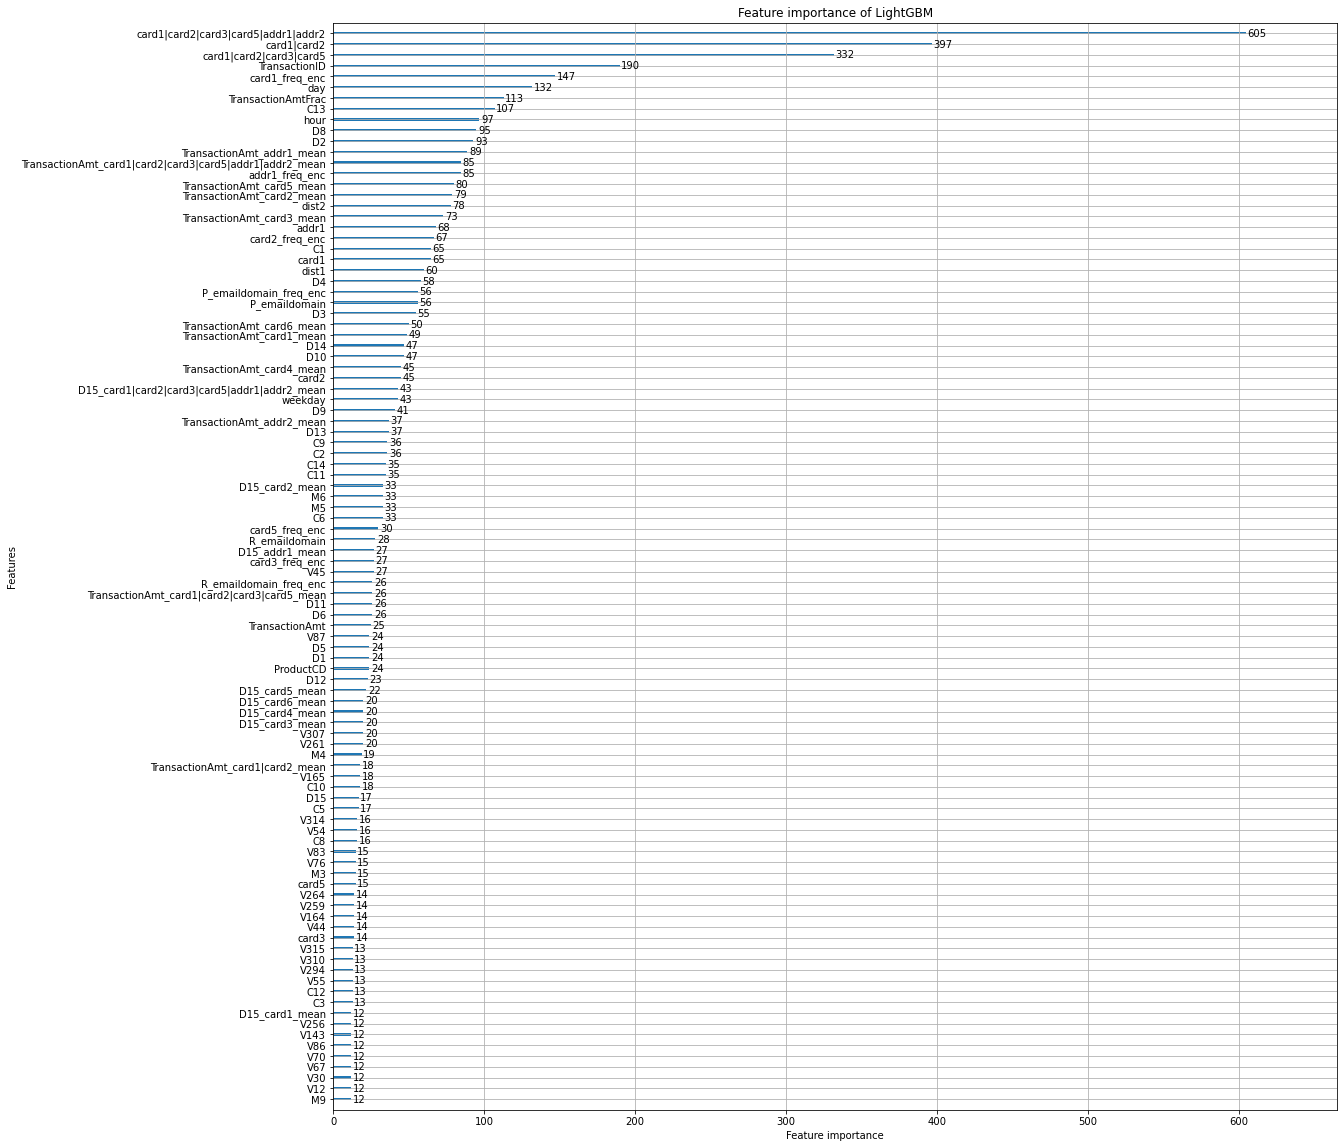

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(18, 20))
ax = lgb.plot_importance(model_base, 
                         ax=ax, 
                         title="Feature importance of LightGBM", 
                         max_num_features=100)
plt.show()

__Задание 2:__ _удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества._

In [11]:
feats_importance = pd.DataFrame({"feats": x_train.columns, "importance": model_base.feature_importance()})\
                                .sort_values(by="importance", ascending=False)
feats_importance

,feats,importance
399,card1|card2|card3|card5|addr1|addr2,605
397,card1|card2,397
398,card1|card2|card3|card5,332
0,TransactionID,190
400,card1_freq_enc,147
...,...,...
230,V178,0
234,V182,0
238,V186,0
54,V2,0


In [12]:
threshold = 0
most_important = feats_importance[feats_importance["importance"]>threshold]
print(f"Count of most important features: {most_important.shape[0]}")

Count of most important features: 337


In [13]:
imp_categorical_features = [elm for elm in categorical_features if elm in most_important["feats"].values]

model = get_trained_model(x_train[most_important["feats"]], y_train, 
                          x_valid[most_important["feats"]], y_valid, 
                          imp_categorical_features, params)

Training until validation scores don't improve for 10 rounds
[20]	training's auc: 0.96586	valid_1's auc: 0.921267
[40]	training's auc: 0.983304	valid_1's auc: 0.933236
[60]	training's auc: 0.991109	valid_1's auc: 0.939041
[80]	training's auc: 0.994634	valid_1's auc: 0.941525
[100]	training's auc: 0.996511	valid_1's auc: 0.943564
[120]	training's auc: 0.997832	valid_1's auc: 0.945142
[140]	training's auc: 0.998495	valid_1's auc: 0.946738
[160]	training's auc: 0.998839	valid_1's auc: 0.94808
[180]	training's auc: 0.999164	valid_1's auc: 0.948596
[200]	training's auc: 0.999424	valid_1's auc: 0.94893
[220]	training's auc: 0.99963	valid_1's auc: 0.949271
[240]	training's auc: 0.999774	valid_1's auc: 0.949624
[260]	training's auc: 0.999818	valid_1's auc: 0.95029
[280]	training's auc: 0.999854	valid_1's auc: 0.950585
Early stopping, best iteration is:
[282]	training's auc: 0.999872	valid_1's auc: 0.95066


In [14]:
get_predict(model, 
            x_train[most_important["feats"]], y_train, 
            x_valid[most_important["feats"]], y_valid,
            x_test[most_important["feats"]], y_test);

Train-score: 0.99987
Valid-score: 0.95066
Test-score: 0.84219


Качество модели на обучающей и валидационной выросло, но на тестовой упало, что говорит о малой эффективности встроенного метода, т.к. измерение важности признаков выполняется косвенным методом.

__Задание 3:__ _использовать permutation importance, выполнить задание 1 и 2._

In [15]:
def _predict(estimator, x_test):
    if hasattr(estimator, "predict_proba"):
        y_pred = estimator.predict_proba(x_test)[:, 1]
    else:
        y_pred = estimator.predict(x_test)

    return y_pred

def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     x_test: pd.DataFrame,
                                     y_test: pd.DataFrame,
                                     maximize: bool = True
                                     ) -> pd.Series:
    """
    Вычисление важности признаков на основе перестановочного
    критерия (permutation importance).

    Parameters
    ----------
    estimator: sklearn-API estimator
        Модель машинного обучения, выполненная в sklearn-API.
        Модель должны быть обученной (применен метод `fit`).

    metric: callable
        Функция для оценки качества прогнозов, функция принимает
        2 аргумента: вектор истинных ответов и вектор прогнозов.

    x_valid: pandas.core.frame.DataFrame
        Матрица признаков для оценки качества модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для оценки качества модели.

    maximize: bool, optional, default = True
        Флаг максимизации метрики качества.
        Опциональный параметр, по умолчанию, равен `True`.
        Если `True`, значит чем выше значение метрики качества,
        тем лучше. Если `False` - иначе.

    """
    y_pred = _predict(estimator, x_test)
    base_score = metric(y_test, y_pred)
    scores, delta = {}, {}

    for feature in tqdm(x_test.columns):
        x_test_ = x_test.copy(deep=True)
        type_features = x_test_[feature].dtype
        x_test_[feature] = np.random.permutation(x_test_[feature])
        x_test_[feature] = x_test_[feature].astype(type_features)

        y_pred = _predict(estimator, x_test_)
        feature_score = metric(y_test, y_pred)

        if maximize:
            delta[feature] = base_score - feature_score
        else:
            delta[feature] = feature_score - base_score

        scores[feature] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

In [16]:
scores, importance = calculate_permutation_importance(model_base, roc_auc_score, x_test, y_test)

100%|████████████████████████████████████████████████████████████████████████████████| 433/433 [22:59<00:00,  3.18s/it]


In [17]:
importance

card1|card2|card3|card5|addr1|addr2    0.017925
V70                                    0.010689
TransactionAmt_addr2_mean              0.008355
C14                                    0.007579
D2                                     0.006848
                                         ...   
V293                                  -0.000735
R_emaildomain_freq_enc                -0.000964
V310                                  -0.000981
V308                                  -0.001656
V315                                  -0.002024
Length: 433, dtype: float64

In [18]:
pi_categorical_features = [elm for elm in categorical_features if elm in importance.index[:337]]

model = get_trained_model(x_train[importance.index[:337]], y_train, 
                          x_valid[importance.index[:337]], y_valid, 
                          pi_categorical_features, params)

Training until validation scores don't improve for 10 rounds
[20]	training's auc: 0.965027	valid_1's auc: 0.921221
[40]	training's auc: 0.983055	valid_1's auc: 0.933991
[60]	training's auc: 0.989574	valid_1's auc: 0.939286
[80]	training's auc: 0.99419	valid_1's auc: 0.942276
[100]	training's auc: 0.996283	valid_1's auc: 0.944321
[120]	training's auc: 0.99734	valid_1's auc: 0.945676
[140]	training's auc: 0.998329	valid_1's auc: 0.946626
[160]	training's auc: 0.998845	valid_1's auc: 0.947313
[180]	training's auc: 0.999297	valid_1's auc: 0.948421
[200]	training's auc: 0.999484	valid_1's auc: 0.948957
[220]	training's auc: 0.999634	valid_1's auc: 0.949527
[240]	training's auc: 0.99978	valid_1's auc: 0.949833
[260]	training's auc: 0.999841	valid_1's auc: 0.950364
Early stopping, best iteration is:
[259]	training's auc: 0.999839	valid_1's auc: 0.950398


In [19]:
get_predict(model, 
            x_train[importance.index[:337]], y_train, 
            x_valid[importance.index[:337]], y_valid, 
            x_test[importance.index[:337]], y_test);

Train-score: 0.99984
Valid-score: 0.9504
Test-score: 0.84084


Качество модели выросло, по сравнению со встроенным методом на том же количестве признаков.

__Задание 4:__ _использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества._

In [20]:
x_train_br = x_train.copy().select_dtypes(exclude=['category'])
y_train_br = y_train.copy()

x_train_br.shape

(126000, 416)

In [21]:
br = BoostARoota(metric='auc')
br.fit(x_train_br, y_train_br);

Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
Round:  3  iteration:  1
Round:  3  iteration:  2
Round:  3  iteration:  3
Round:  3  iteration:  4
Round:  3  iteration:  5
Round:  3  iteration:  6
Round:  3  iteration:  7
Round:  3  iteration:  8
Round:  3  iteration:  9
Round:  3  iteration:  10
BoostARoota ran successfully! Algorithm went through  3  rounds.


In [22]:
br_features = br.keep_vars_.values

In [23]:
br_categorical_features=None

model = get_trained_model(x_train[br_features], y_train, 
                          x_valid[br_features], y_valid, 
                          br_categorical_features, params)

Training until validation scores don't improve for 10 rounds
[20]	training's auc: 0.914392	valid_1's auc: 0.895364
[40]	training's auc: 0.944054	valid_1's auc: 0.910395
[60]	training's auc: 0.963441	valid_1's auc: 0.918523
[80]	training's auc: 0.97383	valid_1's auc: 0.923606
[100]	training's auc: 0.980565	valid_1's auc: 0.927532
[120]	training's auc: 0.984237	valid_1's auc: 0.930019
[140]	training's auc: 0.98765	valid_1's auc: 0.931411
[160]	training's auc: 0.99029	valid_1's auc: 0.933628
[180]	training's auc: 0.992955	valid_1's auc: 0.935899
Early stopping, best iteration is:
[178]	training's auc: 0.992681	valid_1's auc: 0.936001


In [24]:
get_predict(model, 
            x_train[br_features], y_train, 
            x_valid[br_features], y_valid, 
            x_test[br_features], y_test);

Train-score: 0.99268
Valid-score: 0.936
Test-score: 0.83735


Качество модели выросло, но данный метод требователен к памяти, так как для категориальных признаков необходимо применять One Hot Encoding и BoostARoota создает shadow features, что увеличивает размерность данных в два раза, для больших датасетов это огромны объем памяти. Учитывая все особенности метода полноценного сравнения на данном датасете со всеми признаками не выполнить.

__Задание 5:__ _использовать shap, выполнить задание 1 и 2._

In [25]:
explainer = shap.TreeExplainer(model_base)
shap_values = explainer.shap_values(x_test, y_test)

In [26]:
vals= np.abs(shap_values[1]).mean(0)
shap_feature_importance = pd.DataFrame(list(zip(x_test.columns, vals)), columns=['col_name','feature_importance_vals'])
shap_feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
shap_feature_importance.head()

,col_name,feature_importance_vals
399,card1|card2|card3|card5|addr1|addr2,0.439267
0,TransactionID,0.332809
398,card1|card2|card3|card5,0.303114
400,card1_freq_enc,0.250163
397,card1|card2,0.245460


In [27]:
most_imp_shap = shap_feature_importance["col_name"][:337].values

In [28]:
sh_categorical_features = [elm for elm in categorical_features if elm in most_imp_shap]

model = get_trained_model(x_train[most_imp_shap], y_train, 
                          x_valid[most_imp_shap], y_valid, 
                          sh_categorical_features, params)

Training until validation scores don't improve for 10 rounds
[20]	training's auc: 0.96586	valid_1's auc: 0.921267
[40]	training's auc: 0.983304	valid_1's auc: 0.933236
[60]	training's auc: 0.991109	valid_1's auc: 0.939041
[80]	training's auc: 0.994634	valid_1's auc: 0.941525
[100]	training's auc: 0.996511	valid_1's auc: 0.943564
[120]	training's auc: 0.997832	valid_1's auc: 0.94514
[140]	training's auc: 0.998495	valid_1's auc: 0.946737
[160]	training's auc: 0.998839	valid_1's auc: 0.948079
[180]	training's auc: 0.999164	valid_1's auc: 0.948594
[200]	training's auc: 0.999424	valid_1's auc: 0.948929
[220]	training's auc: 0.99963	valid_1's auc: 0.94927
[240]	training's auc: 0.999774	valid_1's auc: 0.949622
[260]	training's auc: 0.999818	valid_1's auc: 0.950288
[280]	training's auc: 0.999854	valid_1's auc: 0.950584
Early stopping, best iteration is:
[282]	training's auc: 0.999872	valid_1's auc: 0.950659


In [29]:
get_predict(model, 
            x_train[most_imp_shap], y_train, 
            x_valid[most_imp_shap], y_valid, 
            x_test[most_imp_shap], y_test);

Train-score: 0.99987
Valid-score: 0.95066
Test-score: 0.84219


Качество модели хуче, чем у базовой и модели со встроенным методом, но данный метод очень мощный и для высокой эффективности необходимо провести более глубокий анализ, что, в итоге, позволит повысить итоговое качество модели.

__Задание 6:__ _построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели._

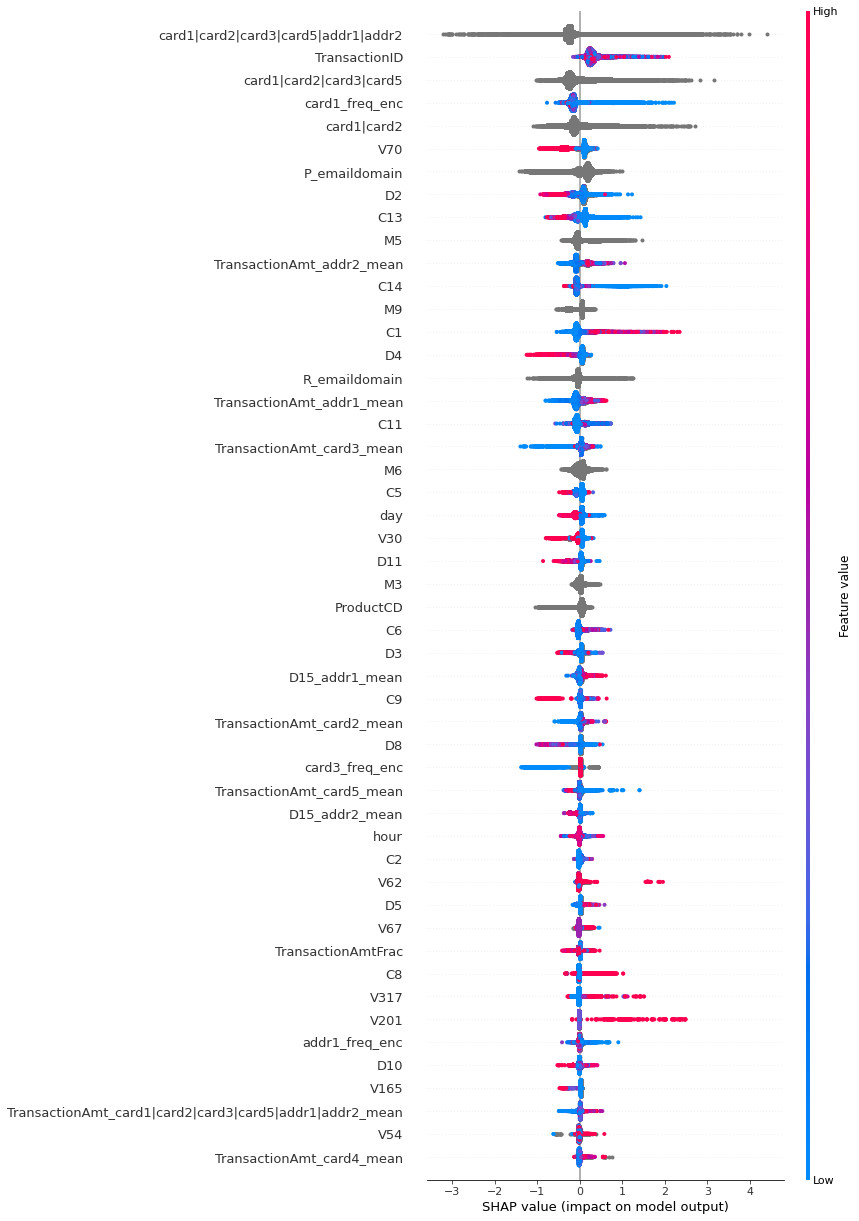

In [30]:
n_samples = 30000
shap.summary_plot(shap_values[1][:n_samples], x_test[:n_samples], max_display=50)

In [32]:
dependence_features = [
    "C11",
    "card1_freq_enc",
    "C1",
    "D2",
    "C13",
    "C14",
    "V70",
    "D4",
    "TransactionAmt_addr1_mean",
]

In [33]:
idx_features = [x_test.columns.get_loc(col) for col in x_test.columns if col in x_test[dependence_features]]

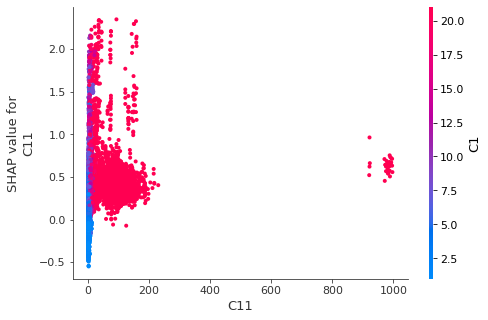

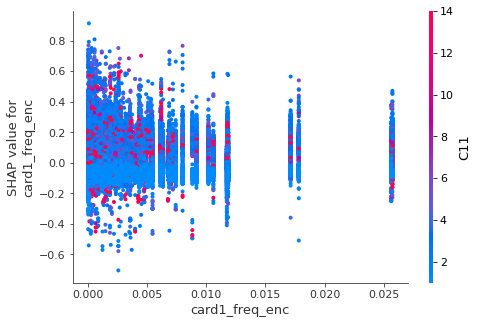

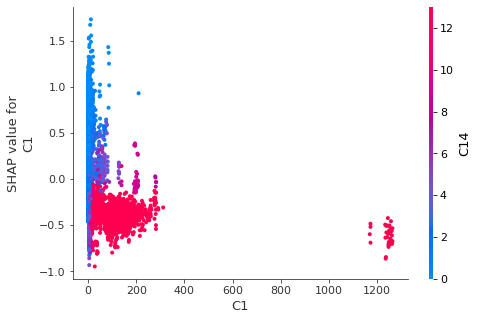

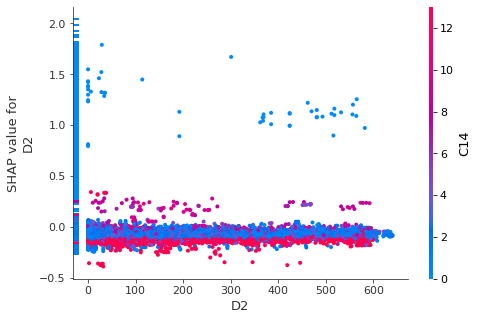

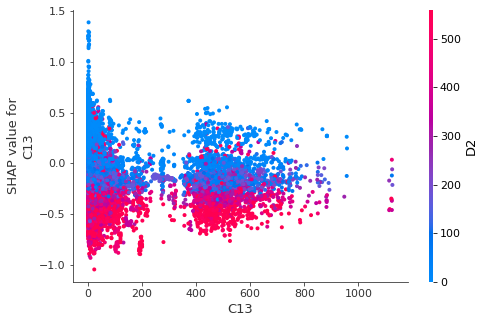

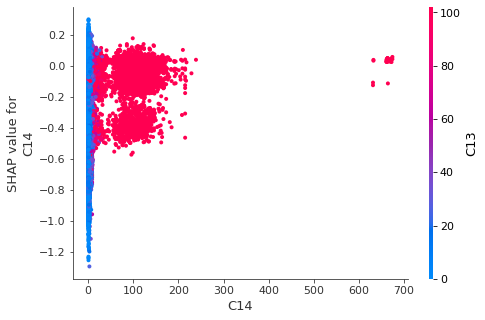

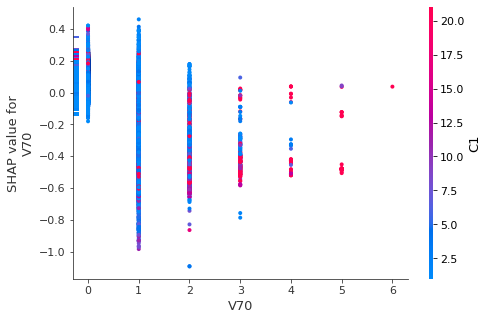

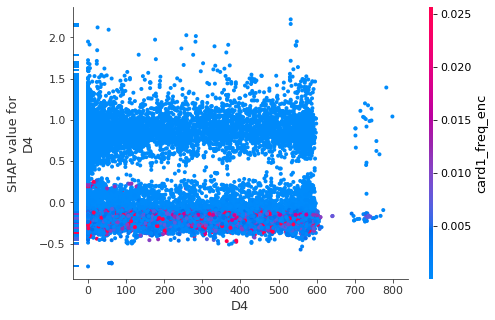

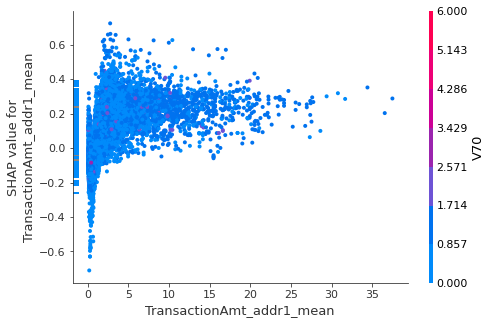

In [34]:
for name in dependence_features:
    shap.dependence_plot(name, shap_values[1][:, idx_features], x_test[dependence_features], feature_names=dependence_features)